# Long Short-Term Memory (LSTM) Networks:

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture used in deep learning, primarily for tasks related to sequential data. LSTMs are designed to address some of the limitations of traditional RNNs, which struggle with capturing long-term dependencies in sequences due to issues like the vanishing gradient problem. Here's a summary of LSTM:

1. **Sequential Data Handling**: LSTMs are particularly well-suited for tasks involving sequential data, such as time series forecasting, natural language processing, speech recognition, and more. They can process and model sequences of data, making them capable of capturing patterns and dependencies over time.

2. **Memory Cells**: LSTMs are composed of memory cells that can store and retrieve information over long sequences. These cells have three main components: an input gate, an output gate, and a forget gate. These gates control the flow of information into and out of the cell, allowing LSTMs to selectively remember and forget information.

3. **Long-Term Dependencies**: LSTMs are designed to mitigate the vanishing gradient problem that plagues traditional RNNs. This enables them to capture long-range dependencies in sequences, making them effective at tasks where context from distant time steps is crucial.

4. **Gating Mechanisms**:
   - **Input Gate**: The input gate regulates the flow of new information into the memory cell. It decides which information from the current time step should be stored in the cell.
   - **Forget Gate**: The forget gate controls what information should be removed or forgotten from the memory cell. It helps in discarding irrelevant or outdated information.
   - **Output Gate**: The output gate determines what information from the memory cell should be used as the output of the LSTM cell for the current time step.

5. **Backpropagation Through Time (BPTT)**: Like other recurrent neural networks, LSTMs use the backpropagation algorithm to train the network. BPTT is used to compute gradients and update the model's parameters during training.

6. **Bidirectional LSTMs (BiLSTM)**: LSTMs can be extended to bidirectional LSTMs, where information from both past and future time steps is considered. This helps capture contextual information from both directions in a sequence.

7. **Applications**: LSTMs have found applications in a wide range of tasks, including:
   - **Natural Language Processing (NLP)**: For tasks like text classification, sentiment analysis, machine translation, and language generation.
   - **Time Series Forecasting**: For predicting future values in time series data.
   - **Speech Recognition**: For converting spoken language into text.
   - **Anomaly Detection**: For identifying unusual patterns in data sequences.
   - **Gesture Recognition**: In computer vision applications.

LSTMs have proven to be highly effective in modeling and making predictions from sequential data, and they have become a foundational tool in the field of deep learning for sequential tasks. Researchers and practitioners continue to explore variations and improvements of LSTM architectures to tackle various challenges in different domains.

In [2]:
# Windows local host
#filepath = 'C:/Users/Alber/PHB009/PHB009/dataset/model/combined_data.csv'
# Google Colab
filepath = '/content/drive/MyDrive/PHB009/dataset/model/combined_data.csv'
save_to = '/content/drive/MyDrive/PHB009/dataset/model/LSTM.csv'

In [3]:
# Training and Testing split
train_end = '2022-12-01'
test_start = '2022-12-02'

# Period for comparison and RMSE calculation (start needs to be test + 30 days)
start_date = '2023-01-01'
end_date = '2023-06-01'

### Grid Search

In [5]:
!pip install scikeras

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Best model: Units=50, Epochs=20, Batch Size=32


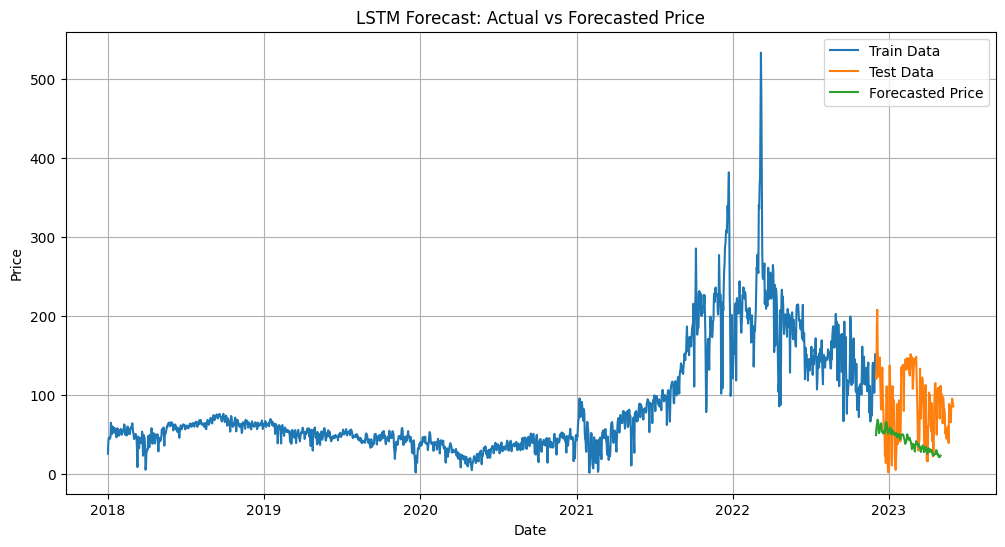

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Read the data into a DataFrame (replace 'your_data.csv' with your actual file)
data = pd.read_csv(filepath, parse_dates=['Date'])

# Select the relevant columns for the LSTM model
columns = ['Date', 'Price', 'GasPrice', 'Demand', 'Non-renewable', 'Renewable', 'Renewable%']  # Replace with your actual column names
lstm_data = data[columns].copy()

# Set the 'Date' column as the index
lstm_data.set_index('Date', inplace=True)

# Divide the data into train and test sets
train_data = lstm_data.loc[lstm_data.index < train_end]
test_data = lstm_data.loc[lstm_data.index >= test_start]

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the number of time steps and features
n_steps = 30  # Number of time steps to consider
n_features = lstm_data.shape[1] - 1  # Number of features (excluding the date column)

# Prepare the data for LSTM training
X_train, y_train = [], []
for i in range(n_steps, len(train_data_scaled)):
    X_train.append(train_data_scaled[i - n_steps:i, 1:])  # Exclude the date and price columns
    y_train.append(train_data_scaled[i, 1])  # Price column
X_train, y_train = np.array(X_train), np.array(y_train)

# Define the function to create the LSTM model
def create_model(units):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the KerasRegressor wrapper for GridSearchCV
model = KerasRegressor(build_fn=create_model, units=50, verbose=0)

# Define the hyperparameters to search over
param_grid = {
    'units': [50, 100],  # Number of LSTM units
    'epochs': [10, 20],  # Number of training epochs
    'batch_size': [32, 64]  # Batch size
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_result.best_estimator_
best_units = grid_result.best_params_['units']
best_epochs = grid_result.best_params_['epochs']
best_batch_size = grid_result.best_params_['batch_size']

print(f"Best model: Units={best_units}, Epochs={best_epochs}, Batch Size={best_batch_size}")

# Train the LSTM model with the best hyperparameters
best_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# Prepare the data for LSTM testing
X_test, y_test = [], []
for i in range(n_steps, len(test_data_scaled)):
    X_test.append(test_data_scaled[i - n_steps:i, 1:])  # Exclude the date and price columns
    y_test.append(test_data_scaled[i, 1])  # Price column
X_test, y_test = np.array(X_test), np.array(y_test)

# Make predictions using the trained LSTM model
forecast_scaled = best_model.predict(X_test)

# Reshape forecast_scaled to match the expected shape
n_samples = len(forecast_scaled)
forecast_reshaped = np.full((n_samples, n_features+1), np.nan)
forecast_reshaped[:, 1] = forecast_scaled.flatten()

# Perform inverse scaling and extract the forecasted price
forecast = scaler.inverse_transform(forecast_reshaped)[:,1]

# Create a DataFrame for the forecasted values
forecast_index = pd.date_range(start=test_data.index[0], periods=len(forecast), freq='D')
forecast_data = pd.DataFrame({'Date': forecast_index, 'Forecasted Price': forecast})

# Plot the actual and forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Price'], label='Train Data')
plt.plot(test_data.index, test_data['Price'], label='Test Data')
plt.plot(forecast_data['Date'], forecast_data['Forecasted Price'], label='Forecasted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('LSTM Forecast: Actual vs Forecasted Price')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, forecast))
print(f"RMSE: {rmse}")

RMSE: 43.60200860997053


### Best model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Read the data into a DataFrame (replace 'your_data.csv' with your actual file)
data = pd.read_csv(filepath, parse_dates=['Date'])

# Assuming 'data' is your DataFrame and 'columns_to_drop' is a list of column names to drop
columns_to_drop = ['Open', 'High', 'Low', 'Close', 'BOMBEO', 'BRENT', 'CARBON', 'CICLOCOMBINADO', 'COGENERACION', 'EOLICA', 'HIDRAULICA', 'NUCLEAR', 'SOLAR', 'TTF']  # Replace with your column names
data.drop(columns=columns_to_drop, inplace=True)
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

# Select the relevant columns for the LSTM model
columns = data.columns.tolist()
lstm_data = data[columns].copy()

# Set the 'Date' column as the index
lstm_data.set_index('Date', inplace=True)

# Define the date range for training (2018-01-01 to 2022-12-31)
train_data = lstm_data.loc[(lstm_data.index <= train_end)]

# Define the date range for testing (2023-01-01 to 2023-06-01)
test_data = lstm_data.loc[(lstm_data.index >= test_start)]

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the number of time steps and features
n_steps = 30  # Number of time steps to consider
n_features = lstm_data.shape[1] - 1  # Number of features (excluding the date column)

# Prepare the data for LSTM training
X_train, y_train = [], []
for i in range(n_steps, len(train_data_scaled)):
    X_train.append(train_data_scaled[i - n_steps:i, 1:])  # Exclude the date and price columns
    y_train.append(train_data_scaled[i, 1])  # Price column
X_train, y_train = np.array(X_train), np.array(y_train)

# Define the function to create the LSTM model
def create_model(units):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the KerasRegressor wrapper for GridSearchCV
best_model = create_model(units=50)
best_epochs = 20
best_batch_size = 64

# Train the LSTM model with the best hyperparameters
best_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# Prepare the data for LSTM testing
X_test, y_test = [], []
for i in range(len(test_data_scaled) - n_steps + 1):
    X_test.append(test_data_scaled[i:i + n_steps, 1:])  # Exclude the date and price columns
X_test = np.array(X_test)

# Make predictions using the trained LSTM model
forecast_scaled = best_model.predict(X_test)

# Reshape forecast_scaled to match the expected shape
n_samples = len(forecast_scaled)
forecast_reshaped = np.full((n_samples, n_features + 1), np.nan)
forecast_reshaped[:, 1] = forecast_scaled.flatten()

# Perform inverse scaling and extract the forecasted price
forecast = scaler.inverse_transform(forecast_reshaped)[:, 1]

# Create a DataFrame for the forecasted values
forecast_index = pd.date_range(start=test_start, periods=len(forecast), freq='D')
forecast_index = forecast_index.shift(n_steps, freq='D')  # Shift the index by n_steps days
forecast_data = pd.DataFrame({'Date': forecast_index, 'Forecasted Price': forecast})

5/5 [==============================] - 0s 6ms/step


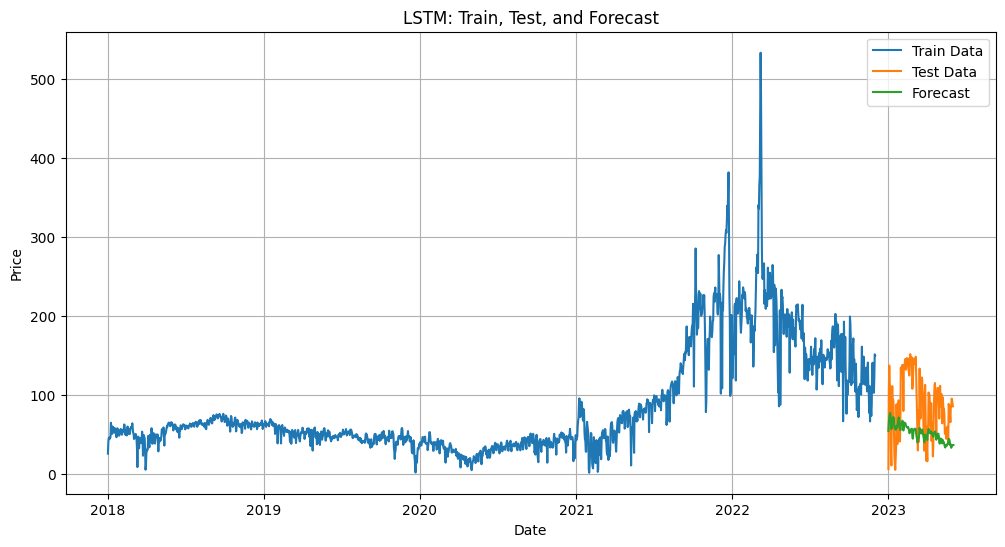

In [ ]:
import matplotlib.pyplot as plt

test_data_subset = test_data[test_data.index >= start_date]

# Convert the train and test data to Matplotlib format
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Price'], label='Train Data')
plt.plot(test_data_subset.index, test_data_subset['Price'], label='Test Data')
plt.plot(forecast_data['Date'], forecast_data['Forecasted Price'], label='Forecast')
plt.title('LSTM: Train, Test, and Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

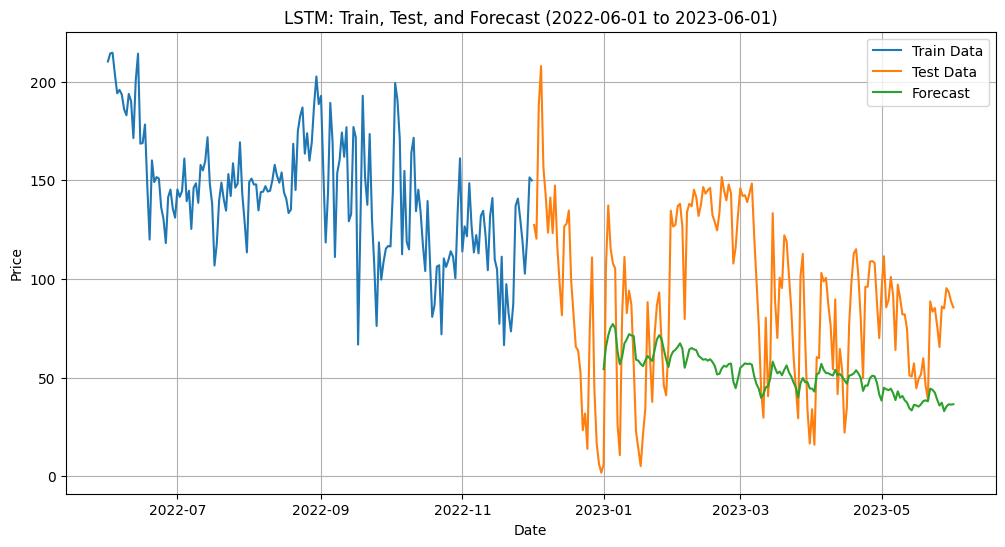

In [ ]:
# Filter data for the desired period
graph_start_date = '2022-06-01'
train_data_filtered = train_data[(train_data.index >= graph_start_date) & (train_data.index <= end_date)]
test_data_filtered = test_data[(test_data.index >= graph_start_date) & (test_data.index <= end_date)]
forecast_filtered = forecast_data[(forecast_data['Date'] >= graph_start_date) & (forecast_data['Date'] <= end_date)]

# Plot the filtered train, test, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data_filtered.index, train_data_filtered['Price'], label='Train Data')
plt.plot(test_data_filtered.index, test_data_filtered['Price'], label='Test Data')
plt.plot(forecast_filtered['Date'], forecast_filtered['Forecasted Price'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('LSTM: Train, Test, and Forecast (2022-06-01 to 2023-06-01)')
plt.legend()
plt.grid(True)
plt.show()

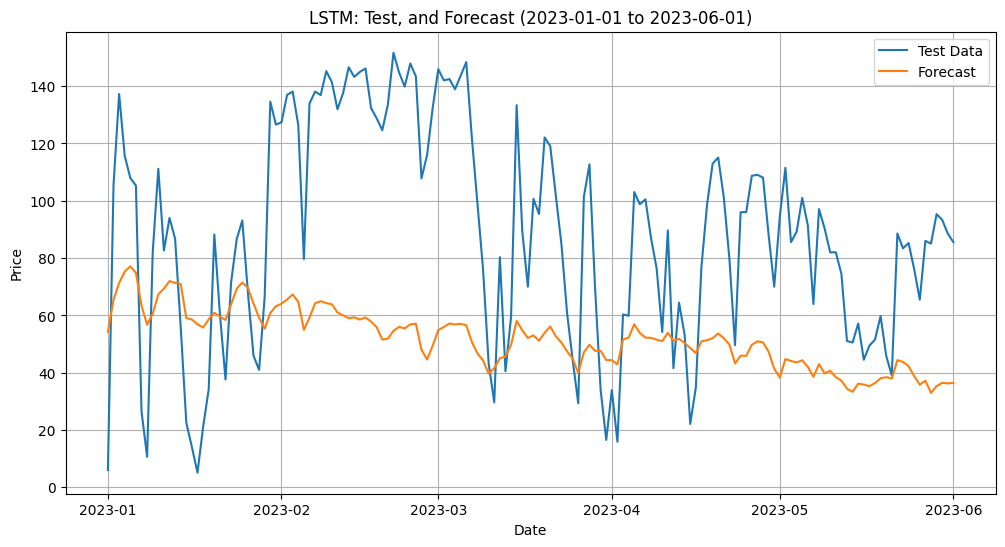

In [ ]:
# Filter data for the desired period
test_data_filtered = test_data[(test_data.index >= start_date) & (test_data.index <= end_date)]
forecast_filtered = forecast_data[(forecast_data['Date'] >= start_date) & (forecast_data['Date'] <= end_date)]

# Plot the filtered train, test, and forecast
plt.figure(figsize=(12, 6))
plt.plot(test_data_filtered.index, test_data_filtered['Price'], label='Test Data')
plt.plot(forecast_filtered['Date'], forecast_filtered['Forecasted Price'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('LSTM: Test, and Forecast (2023-01-01 to 2023-06-01)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

future_periods = 152

# Assuming forecast_filtered and test_data_filtered are DataFrames

# Copy the forecast_filtered DataFrame to avoid modifying the original data
forecast_filtered_copy = forecast_filtered.copy()

# Assign the 'y' values from test_data_filtered to the copy
forecast_filtered_copy.loc[:, 'Price'] = test_data_filtered['Price'].values

# Extract actual values
actual_values = forecast_filtered_copy['Price'].values

# Extract predicted values
predicted_values = forecast_filtered_copy['Forecasted Price'].values[-future_periods:]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 50.76


In [ ]:
# Rename the columns
forecast_filtered_copy.rename(columns={'Forecasted Price':'Prediction'}, inplace=True)

In [ ]:
# Reset the index
forecast_filtered_copy.reset_index(drop=True, inplace=True)
forecast_filtered_copy[['Date','Price','Prediction']]

,Date,Price,Prediction
0,2023-01-01,6.034583,54.253737
1,2023-01-02,105.573333,65.417894
2,2023-01-03,137.238333,71.346593
3,2023-01-04,115.684167,75.271491
4,2023-01-05,107.924583,77.135988
...,...,...,...
147,2023-05-28,85.040833,32.953107
148,2023-05-29,95.328750,35.317820
149,2023-05-30,93.355833,36.454223
150,2023-05-31,88.555833,36.258914


In [ ]:
forecast_filtered_copy[['Date','Price','Prediction']].to_csv('/content/drive/MyDrive/PHB009/dataset/model/results/1DLSTMResults.csv')

## Interactive Graphs

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Convert the train and test data to Plotly format
train_trace = go.Scatter(x=train_data.index, y=train_data['Price'], name='Train Data')
test_trace = go.Scatter(x=test_data.index, y=test_data['Price'], name='Test Data')
forecast_trace = go.Scatter(x=forecast_data['Date'], y=forecast_data['Forecasted Price'], name='Forecasted Price')

# Create the figure layout
layout = go.Layout(
    title='LSTM Forecast: Actual vs Forecasted Price',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    legend=dict(orientation='h', x=0.1, y=-0.2),
    template='plotly_white'
)

# Create the figure object
fig = go.Figure(data=[train_trace, test_trace, forecast_trace], layout=layout)

# Show the interactive graph
pio.show(fig)

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Filter data for the desired period
start_date = '2022-06-01'
end_date = '2023-06-01'
train_data_filtered = train_data[(train_data.index >= start_date) & (train_data.index <= end_date)]
test_data_filtered = test_data[(test_data.index >= start_date) & (test_data.index <= end_date)]
forecast_data_filtered = forecast_data[(forecast_data['Date'] >= start_date) & (forecast_data['Date'] <= end_date)]

# Convert the filtered train and test data to Plotly format
train_trace = go.Scatter(x=train_data_filtered.index, y=train_data_filtered['Price'], name='Train Data')
test_trace = go.Scatter(x=test_data_filtered.index, y=test_data_filtered['Price'], name='Test Data')
forecast_trace = go.Scatter(x=forecast_data_filtered['Date'], y=forecast_data_filtered['Forecasted Price'], name='Forecasted Price')

# Create the figure layout
layout = go.Layout(
    title='LSTM Forecast: Actual vs Forecasted Price (2022-06-01 to 2023-06-01)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    legend=dict(orientation='h', x=0.1, y=-0.2),
    template='plotly_white'
)

# Create the figure object
fig = go.Figure(data=[train_trace, test_trace, forecast_trace], layout=layout)

# Show the interactive graph
pio.show(fig)

# Projection 2023-06-01 to 2023-08-16 with no extra data

Retrain the model with all the previous dates and forecast for the validation period

In [ ]:
# Define the date range for training (2018-01-01 to 2022-12-31)
train_data = lstm_data.loc[(lstm_data.index <= '2023-05-31')]

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Define the number of time steps and features
n_steps = 30  # Number of time steps to consider
n_features = lstm_data.shape[1] - 1  # Number of features (excluding the date column)

# Prepare the data for LSTM training
X_train, y_train = [], []
for i in range(n_steps, len(train_data_scaled)):
    X_train.append(train_data_scaled[i - n_steps:i, 1:])  # Exclude the date and price columns
    y_train.append(train_data_scaled[i, 1])  # Price column
X_train, y_train = np.array(X_train), np.array(y_train)

# Define the function to create the LSTM model
def create_model(units):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

best_model = create_model(units=50)
best_epochs = 20
best_batch_size = 64

# Train the LSTM model with the best hyperparameters
best_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

In [ ]:
# Define the number of additional time steps for the extended forecast
n_additional_steps = 77
n_features = lstm_data.shape[1] - 1

# Get the last n_steps data points from the test set as initial input
X_forecast = train_data_scaled[-n_steps:, 1:]

# Initialize a list to store forecasted prices
forecasted_prices = []

# Forecast for the desired number of time steps
for _ in range(n_additional_steps):
    # Reshape the input data for LSTM
    X_forecast_reshaped = X_forecast.reshape(1, n_steps, n_features)

    # Make a prediction using the trained LSTM model
    forecast_scaled = best_model.predict(X_forecast_reshaped)

    # Reshape forecast_scaled to match the expected shape
    n_samples = len(forecast_scaled)
    forecast_reshaped = np.full((n_samples, n_features+1), np.nan)
    forecast_reshaped[:, 1] = forecast_scaled.flatten()

    # Perform inverse scaling and extract the forecasted price
    forecast = scaler.inverse_transform(forecast_reshaped)[:,1]

    # Append the forecasted price to the list
    forecasted_prices.append(forecast[0])

    # Update X_forecast for the next iteration by shifting the values and adding the new forecasted value
    X_forecast = np.roll(X_forecast, -1, axis=0)
    X_forecast[-1, 1] = forecast_scaled  # Update the last value in the sequence
    print(X_forecast[-1, 1])

# Create a DataFrame for the extended forecasted prices
forecasted_index = pd.date_range(start='2023-06-01', periods=n_additional_steps, freq='D')

In [ ]:
# Specify the directory where your result files are stored
file_path = '/content/drive/MyDrive/PHB009/dataset/precio electricidad OMIE/Jun-Ago2023/energyPricesValidation.csv'
df = pd.read_csv(file_path)

extended_forecast_data = pd.DataFrame({'Date': forecasted_index, 'Projection': forecasted_prices})

# Use the 'Date' column as the index
df.set_index('Date', inplace=True)
extended_forecast_data.set_index('Date', inplace=True)

# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)
extended_forecast_data.index = pd.to_datetime(df.index)

merged_df = df.merge(extended_forecast_data, left_index=True, right_index=True)

import plotly.graph_objects as go
import plotly.io as pio

# Convert the train and test data to Plotly format
actuals = go.Scatter(x=merged_df.index, y=merged_df['Price'], name='Actual Price')
projections = go.Scatter(x=merged_df.index, y=merged_df['Projection'], name='Projected Price')

# Create the figure layout
layout = go.Layout(
    title='LSTM Forecast: Actual vs Projected Price',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    legend=dict(orientation='h', x=0.1, y=-0.2),
    template='plotly_white'
)

# Create the figure object
fig = go.Figure(data=[actuals, projections], layout=layout)

# Show the interactive graph
pio.show(fig)

merged_df[['Price','Projection']].to_csv('/content/drive/MyDrive/PHB009/dataset/model/projections/1DLSTMResults.csv')